# Movie Curiosities: An IMDB Exploration

## Introduction

In this project, I'm going to explore a movie dataset to attempt to answer few, broad questions regarding movie budgets, revenues, scores, etc. I built this dataset combining together three separate ones; if you're interested, you can see how I did it in the notebook [imdb_wrangling.ipynb](https://github.com/NicolaBagala/portfolio/blob/master/imdb/imdb_wrangling.ipynb) found in the same repository as this one. 

Some of the charts in this notebook are "convenience" charts made on-the-fly to spot interesting patterns, as opposed to more sophisticated charts intended for presentations.

(**Note:** If you'd rather read the code-free version of this project, you can find it [here](https://github.com/NicolaBagala/portfolio/blob/master/imdb/codefree/imdb_exploration_codefree.ipynb).)

## Setting up

Let's quickly import and set up few things we're going to need.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib
%matplotlib inline
plt.style.use("fivethirtyeight")

axis_labels_fontsize = "medium"

## The dataset

The dataset we'll work with is called `imdb_final.csv`. Let's familiarise with it.

In [2]:
imdb = pd.read_csv("imdb_final.csv", header = 0)
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  85855 non-null  object 
 1   TITLE               85855 non-null  object 
 2   RELEASE_YEAR        85855 non-null  int64  
 3   GENRE               85855 non-null  object 
 4   LENGTH_MIN          85855 non-null  int64  
 5   COUNTRY             85855 non-null  object 
 6   BUDGET_USD          13397 non-null  float64
 7   GLOBAL_GROSS_USD    30955 non-null  float64
 8   WAVG_SCORE          85855 non-null  float64
 9   VOTES               85855 non-null  int64  
 10  M_AVG_SCORE         85854 non-null  float64
 11  M_017_AVG_SCORE     27411 non-null  float64
 12  M_1829_AVG_SCORE    84390 non-null  float64
 13  M_3044_AVG_SCORE    85843 non-null  float64
 14  M_45PLUS_AVG_SCORE  85754 non-null  float64
 15  F_AVG_SCORE         85774 non-null  float64
 16  F_01

The dataset contains 20 columns, which I'll summarise briefly:

- `ID` is a unique alphanumeric string automatically assigned by IMDB to each movie.

- `TITLE` is the original title of a movie.
- `RELEASE_YEAR` is the year when a movie was [first released](https://help.imdb.com/article/contribution/titles/release-dates/GVUUDEPJNAW6G35P#) to the public.
- `GENRE` is a string specifying the genres that apply to a movie.
- `LENGTH_MIN` is the length of a movie, in minutes.
- `COUNTRY` is a string specifying the origin country (or countries) of a movie.
- `BUDGET_USD` and `GLOBAL_GROSS_USD` are the budget and worldwide gross of a movie, expressed in inflation-adjusted 2021 United States Dollars. Null values mean the specific figure is not available.
- `WAVG_SCORE` is a weighted average of the scores that IMDB users have given to the movie. This value is calculated by IMDB according to a formula that [they chose not to disclose](https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK?ref_=helpsect_pro_2_8#). In the text, I sometimes refer to this score as the 'IMDB score'.
- `VOTES` is the number of votes that a movie has received from IMDB users. (Users can vote only once for each given movie, so `VOTES` is equivalent to the number of IMDB users who cast a vote on a given movie.)
- `M_AVG_SCORE` and `F_AVG_SCORE` contain the average score given to each movie by male and female IMDB users, respectively. Null values mean that the average score of the specific sex is unavailable.
- `M_017_AVG_SCORE` to `M_45PLUS_AVG_SCORE` break down a movie's average score by age brackets for male voters (`45PLUS` means age 45 and above). For example, if `M_017_AVG_SCORE` was 7.3 for *The Prestige*, it would mean that the average score that IMDB male users between the ages of 0 and 17 gave to that movie is 7.3. Null values mean that the average score for the given bracket is unavailable. Similarly, columns `F_017_AVG_SCORE` to `F_45PLUS_AVG_SCORE` refer to female users only.

## Exploring the dataset

Broadly speaking, we'll deal with three kinds of questions, plus any further questions that may originate from them as we go:

- questions regarding movie budgets and revenues,
- questions about movie length, and
- questions about movie scores.

### Of budgets and revenues

In this section, we're going to try to answer three main questions:

1. **How did movie budgets change over time?**
2. **How did movie revenues change over time?**
3. **Is there a correlation between movie budgets and movie revenues?**

(You'll notice I'm using the word "revenue" to refer to the global gross of movies, indicated in the dataset column `GLOBAL_GROSS_USD`. That's because a) "revenue" is shorter than "global gross", and b) the word "gross" is, well, gross.) 

Of course, changes in budgets and revenues can depend on many things—for example, it's possible that budgets would go up in some countries, but down in others. What we're aiming for is a broad overview, so in general, we're going to settle for worldwide averages. (Keep in mind that several budget and revenue values were intentionally eliminated from the dataset during the wrangling phase, because they were unsuitable for various reasons.)

#### Budgets go up...

We'll look into budgets first; let's start by selecting columns of interests from the dataset, and then further choose only those movies of which we know the budgets.

In [3]:
budget_and_revenues = imdb[["TITLE", "RELEASE_YEAR", "BUDGET_USD", "GLOBAL_GROSS_USD"]]
movies_with_budget = budget_and_revenues.loc[budget_and_revenues["BUDGET_USD"].notna(), :]

As we've seen when we introduced the dataset, we don't have budget information for all movies in the dataset: only short of 14000 movies come with that information, and the number of movies with known budget varies pretty much each year.

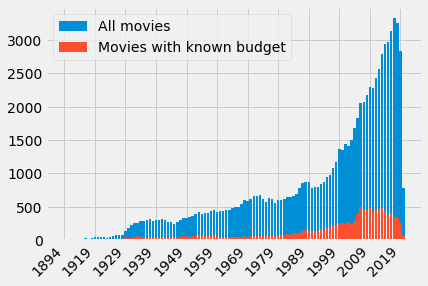

In [6]:
all_years = imdb["RELEASE_YEAR"].unique()
tot_movies_by_year = imdb.groupby("RELEASE_YEAR").size()
movies_with_budget_by_year = movies_with_budget.groupby("RELEASE_YEAR")

# If a year has no movies with known budget, put a 0 in there. Make sure the series is sorted by year (index), in ascending order.
tot_movies_with_budget_by_year = pd.Series(movies_with_budget_by_year.size(), index = all_years).fillna(0).astype(int).sort_index()

# Utility chart to see how many movies and movie budgets we have per year.
fig_movies_and_budgets, ax_movies_and_budgets = plt.subplots(1, 1)

bar_locations = [i for i in range(len(all_years))]

# Bar chart: all movies, by year
ax_movies_and_budgets.bar(x = bar_locations,
                          height = tot_movies_by_year,
                          label = "All movies",
                          tick_label = tot_movies_with_budget_by_year.index)

# Bar chart: all movies with known budget, by year
ax_movies_and_budgets.bar(x = bar_locations,
                          height = tot_movies_with_budget_by_year,
                          label = "Movies with known budget")

# Rotate the labels for legibility, and show only some of them.
ax_movies_and_budgets.set_xticklabels(ax_movies_and_budgets.get_xticklabels(), rotation = 45, ha = "right")
ax_movies_and_budgets.xaxis.set_major_locator(plt.MaxNLocator(15))

ax_movies_and_budgets.legend();

_`Figure 1. Movies with budget vs movies in the dataset, by year.`_

This means that, for some years, we'll likely have a less accurate average budget, because we have far fewer budgets to calculate it from. With that caveat in mind, let's calculate and plot the average budget for each given year.

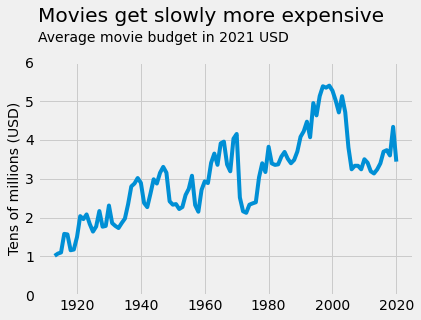

In [5]:
avg_budget_by_year = movies_with_budget_by_year["BUDGET_USD"].mean()

# Plot the data.
fig_avg_budget, ax_avg_budget = plt.subplots(1, 1)
ax_avg_budget.plot(avg_budget_by_year)
ax_avg_budget.set_ylabel("Tens of millions (USD)", fontsize = axis_labels_fontsize)

# Format ytick labels more nicely.
yticks = ax_avg_budget.get_yticks()
ax_avg_budget.set_yticks(yticks, [i for i in range(len(yticks))])
ax_avg_budget.set_title("Movies get slowly more expensive", pad = 40, loc = "left");
ax_avg_budget.text(0.08, 0.95, "Average movie budget in 2021 USD", transform = fig_avg_budget.transFigure);

_`Figure 2. Average movie budget by year.`_

At a glance, it looks like **movie budgets have been growing somewhat steadily, though with a lot of ups and downs.** This might be for a number of reasons—for example, fewer (or more) movies might have been produced in a given year, or maybe they were less (or more) expensive compared to movies from other years.

#### ...but revenues go down

Next, we can look into how movie revenues have been changing over the years. As before, we don't know the revenue for every movie in the dataset. Before the 60s, there's basically no revenue information to speak of.

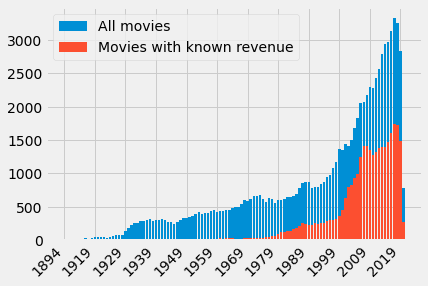

In [6]:
movies_with_revenue = budget_and_revenues.loc[budget_and_revenues["GLOBAL_GROSS_USD"].notna(), :]
movies_with_revenue_by_year = movies_with_revenue.groupby("RELEASE_YEAR")

# If a year has no movies with known revenue, put a 0 in there. Make sure the series is sorted by year (index), in ascending order.
# (`bar_locations` and `all_years` were initialised above; they can be reused for this chart just fine.)
tot_movies_with_revenue_by_year = pd.Series(movies_with_revenue_by_year.size(), index = all_years).fillna(0).astype(int).sort_index()

# Utility chart to see how many movies and movie revenues we have per year. 
fig_movies_and_revenues, ax_movies_and_revenues = plt.subplots(1, 1)
 
# Bar chart: all movies, by year
ax_movies_and_revenues.bar(x = bar_locations,
                          height = tot_movies_by_year,
                          label = "All movies",
                          tick_label = tot_movies_with_revenue_by_year.index)

# Bar chart all movies with known revenue, by year
ax_movies_and_revenues.bar(x = bar_locations,
                          height = tot_movies_with_revenue_by_year,
                          label = "Movies with known revenue")

# Rotate the labels for legibility, and show only some of them.
ax_movies_and_revenues.set_xticklabels(ax_movies_and_revenues.get_xticklabels(), rotation = 45, ha = "right")
ax_movies_and_revenues.xaxis.set_major_locator(plt.MaxNLocator(15))

ax_movies_and_revenues.legend();

_`Figure 3. Movies with revenue vs movies in the dataset, by year.`_

If we calculate and plot the average worldwide movie revenue by year, you can immediately tell that something's off.

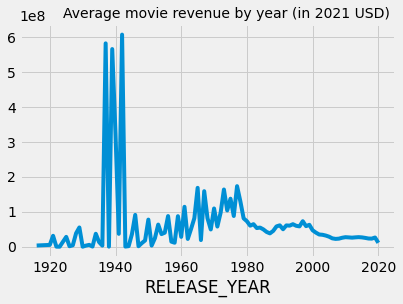

In [7]:
avg_revenue_by_year =  movies_with_revenue_by_year["GLOBAL_GROSS_USD"].mean()
avg_revenue_by_year.plot(); # No need for a fancier chart, this is for our reference only.
plt.title("Average movie revenue by year (in 2021 USD)",  fontsize = "medium", x = 0.55);

_`Figure 4. Average movie revenue by year.`_

There are _huge_ spikes around the 1940s, and while there may well be ridiculously high-grossing outliers from that time ([_Gone with the Wind_](https://en.wikipedia.org/wiki/Gone_with_the_Wind_(film)) being one), this is likely an artefact due to the lack of revenue data for that time period. Let's have a look at what's causing the spikes; then we'll try to restrict the chart to a more sensible time frame.

In [8]:
outliers_range = movies_with_revenue.query("RELEASE_YEAR >= 1935 and RELEASE_YEAR <= 1942")
outliers_range.sort_values("GLOBAL_GROSS_USD", ascending = False).head(10)

,TITLE,RELEASE_YEAR,BUDGET_USD,GLOBAL_GROSS_USD
3266,Gone with the Wind,1939,77651640.0,7.856006e+09
4104,Bambi,1942,NaN,4.453077e+09
2827,Snow White and the Seven Dwarfs,1937,28251986.0,3.485332e+09
3672,Pinocchio,1940,50402857.0,2.362964e+09
3553,Fantasia,1940,44199429.0,1.481290e+09
3451,The Wizard of Oz,1939,54221424.0,5.104279e+08
4012,Sergeant York,1941,25847619.0,3.021388e+08
4332,Tarzan's New York Adventure,1942,NaN,9.869336e+07
3419,Tarzan Finds a Son!,1939,NaN,8.887550e+07
4208,Kings Row,1942,NaN,8.480001e+07


_`Table 1. Ten top-grossing movies from 1937 to 1942.`_

The ten movies above have made a lot of money—sometimes in the order of _billions!_ However, only a handful of movies from the same period come with revenue data, so this is what's causing the absurdly huge spikes. From the chart in `Figure 3`, it is difficult to tell exactly how many movies come with revenue data each year, so let's choose a threshold manually. Around the time of the spikes, there are only about 8 known revenues per year:

In [9]:
print("Average number of movies with known revenue between 1935 and 1945: ", movies_with_revenue_by_year.size().loc[1935:1945].mean())

Average number of movies with known revenue between 1935 and 1945:  7.909090909090909


That is very little, so, let's say instead that we want at least 25 known revenues in a year to bother calculating the average revenue for that year, and let's plot that subset of the data.

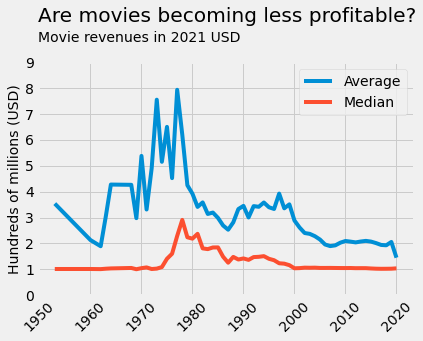

In [10]:
at_least_25_revenues_by_year = movies_with_revenue_by_year.filter(lambda year_group: len(year_group) >= 25).groupby("RELEASE_YEAR")
avg_revenue_by_year_25plus = at_least_25_revenues_by_year["GLOBAL_GROSS_USD"].mean()
median_revenue_by_year_25plus = at_least_25_revenues_by_year["GLOBAL_GROSS_USD"].median()

# Plot the data.
fig_avg_revenue, ax_avg_revenue = plt.subplots(1, 1) 
ax_avg_revenue.plot(avg_revenue_by_year_25plus, label = "Average")
ax_avg_revenue.plot(median_revenue_by_year_25plus, label = "Median")
ax_avg_revenue.set_ylabel("Hundreds of millions (USD)", fontsize = axis_labels_fontsize)

# Format ytick labels more nicely.
yticks = ax_avg_revenue.get_yticks()
ax_avg_revenue.set_yticks(yticks, [i for i in range(len(yticks))])
ax_avg_revenue.tick_params(axis = "x", labelrotation = 45)
ax_avg_revenue.set_title("Are movies becoming less profitable?", pad = 40, loc = "left");
ax_avg_revenue.text(0.08, 0.95, "Movie revenues in 2021 USD", transform = fig_avg_revenue.transFigure)
ax_avg_revenue.legend();

_`Figure 5. Average and median movie revenue by year. (Only years with 25 or more movies.)`_

Naturally, the same trend we saw in `Figure 4` is still there—it seems that **movie revenues are slowly going down on average.** This is not related to how many data points we have: especially after the year 2000, there's plenty of revenue information for all years, except for 2020 (which is around the time when the original dataset was created). Even the median revenue per year (in red) shows a decline spanning from the late 70s to the year 2000. However, before and after this timeframe, the median is essentially flat; this is true also for the median across _all_ available revenues.

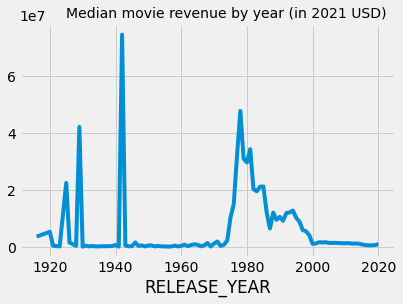

In [11]:
median_revenue_by_year =  movies_with_revenue_by_year["GLOBAL_GROSS_USD"].median()
median_revenue_by_year.plot()
plt.title("Median movie revenue by year (in 2021 USD)", fontsize = "medium", x = 0.55);

_`Figure 6. Median movie revenue by year. (All years in the dataset.)`_

Barring the exceptional spikes from the 40s and before, it seems that the median movie revenue has been virtually the same, around 1.000.000 2021-USD, _except_ for a sudden peak in the late 70s that took over 20 years to fully disappear. In the chart below, we're showing revenues from three time frames: 1945-1975, 1976-2000, and 2000-2020. The maximum revenue, represented by the end of each top whisker, is very similar across the three time frames, and the three average revenues—in blue—aren't that far apart from each other either. However, the three median revenues (in red) all have different orders of magnitude: the 1945-1975 median is around \\$460.000; the 1976-2000 median is about \\$11 million, and the 2001-2020 median is around \\$1 million. This means, for example, that 50\% of the movies from 1976-2000 grossed at least $11 million. Below the upper edge of each golden box lie seventy-five percent of the revenues, so **50\% of the movies from 1976-2000 had a higher revenue than 75\% of the movies from both the other two time frames!**

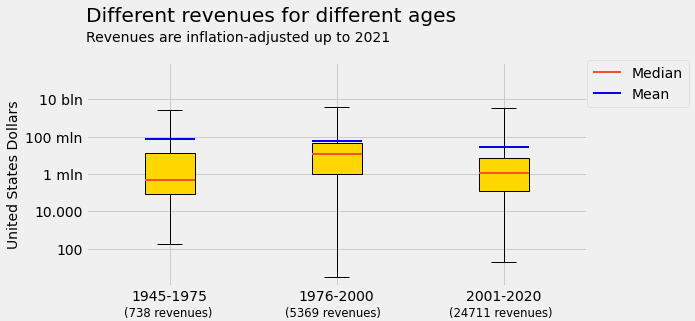

In [12]:
revenues_45_75 = movies_with_revenue.query("RELEASE_YEAR >= 1945 and RELEASE_YEAR <= 1975")["GLOBAL_GROSS_USD"]
revenues_76_20 = movies_with_revenue.query("RELEASE_YEAR >= 1976 and RELEASE_YEAR <= 2000")["GLOBAL_GROSS_USD"]
revenues_over_2000 = movies_with_revenue.query("RELEASE_YEAR > 2000")["GLOBAL_GROSS_USD"]

# Draw a boxplot.
fig_revenue_box, ax_revenue_box = plt.subplots(1, 1, figsize = (8, 4))
 
meanprops = {"color": "blue",
             "linewidth": 2,
             "linestyle": "solid"}

medianprops = {"linewidth": 2}

# Store the boxplot components for later, to populate the legend manually.
revenue_dict = ax_revenue_box.boxplot([revenues_45_75, revenues_76_20, revenues_over_2000], 
                                      labels = ["1945-1975", "1976-2000", "2001-2020"],
                                      showmeans = True, 
                                      meanline = True,
                                      whis = (0, 100),
                                      meanprops = meanprops,
                                      medianprops = medianprops,
                                      patch_artist = True);

for box in revenue_dict["boxes"]:
    box.set_facecolor("gold")

# Add the number of revenues available during each time frame, as a separate text beneath the xtick labels.
fig_revenue_box.subplots_adjust(bottom = 0.1)
ax_revenue_box.text(0.286, 0.015, "({} revenues)".format(len(revenues_45_75)), transform = fig_avg_revenue.transFigure, fontsize = "small")
ax_revenue_box.text(0.66, 0.015, "({} revenues)".format(len(revenues_76_20)), transform = fig_avg_revenue.transFigure, fontsize = "small")
ax_revenue_box.text(1.04, 0.015, "({} revenues)".format(len(revenues_over_2000)), transform = fig_avg_revenue.transFigure, fontsize = "small")
    
# CHange the scale and range of the y-axis to make it more legible.
ax_revenue_box.set_ylim(100, 10**10)
ax_revenue_box.set_yscale("log")
ax_revenue_box.set_yticks(ax_revenue_box.get_yticks(), ["", "100", "10.000", "1 mln", "100 mln", "10 bln", "" ]);
ax_revenue_box.set_ylabel("United States Dollars", fontsize = axis_labels_fontsize)

# Populate the legend manually.
ax_revenue_box.legend([revenue_dict["medians"][0], revenue_dict["means"][0]], ["Median", "Mean"], loc = (1, 0.8))

ax_revenue_box.set_title("Different revenues for different ages", pad = 40, loc = "left");
ax_revenue_box.text(0.2, 0.97, "Revenues are inflation-adjusted up to 2021", transform = fig_avg_revenue.transFigure);

_`Figure 7. Mean, median and quartiles of movie revenues from 1945-1975, 1976-2000, and 2001-2020.`_

In short, this suggests that **movies between 1976 and 2000 generally grossed more than movies from the other two time periods**, although the rather different number of revenues available might be affecting this result. Movies outside the 1976-2000 peak _did_ gross less on average, but the peak may well be just an exception. What might have caused it is an interesting question, but it's beyond the scope of this project.

#### Spend more, earn more?

It's fair to wonder whether more expensive movies tend to make more money than less expensive ones. To try to answer that question, we can look for a correlation between movie budgets and movie revenues. Let's select all movies for which we have both budget and gross information, and see if these two figures correlate in any way. 

In [13]:
movies_with_budget_and_revenue = budget_and_revenues.loc[(budget_and_revenues["BUDGET_USD"].notnull()) & 
                                                       (budget_and_revenues["GLOBAL_GROSS_USD"].notnull()), 
                                                       ["BUDGET_USD", "GLOBAL_GROSS_USD"]].copy() # We make a copy, because we're going to modify things later on.

print("Movies with both budget and revenue available: ", len(movies_with_budget_and_revenue))
budget_revenue_corr = movies_with_budget_and_revenue["BUDGET_USD"].corr(movies_with_budget_and_revenue["GLOBAL_GROSS_USD"])
print("Pearson correlation between budgets and revenues: ", budget_revenue_corr)

Movies with both budget and revenue available:  7148
Pearson correlation between budgets and revenues:  0.5998495559869299


There is a moderate positive correlation, suggesting that these two values may indeed go up or down together in a linear fashion. However, a quick scatter plot shows that most movies cluster to the bottom left of the chart.

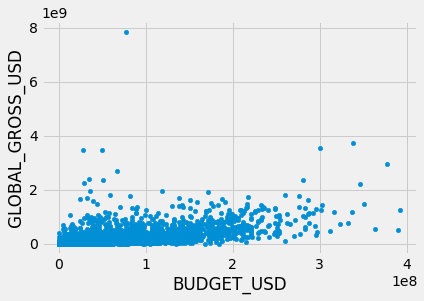

In [14]:
movies_with_budget_and_revenue.plot.scatter("BUDGET_USD", "GLOBAL_GROSS_USD");

_`Figure 8. Movie revenue vs movie budget.`_

While we can see a slight upward trend as the budget grows, the jungle of points in the lower-left quadrant makes it difficult to spot any pattern. We can try to "zoom in" on movies with a budget below 200.000.000 USD, and take a smaller random sample to avoid an overly crowded chart.

In [15]:
budget_below_200mln = movies_with_budget_and_revenue.query("BUDGET_USD <= 2 * 10**8")
print("Number of movies with budget below 200 mln USD: ", len(budget_below_200mln))

Number of movies with budget below 200 mln USD:  7004


Let's try with a sample about half that size.

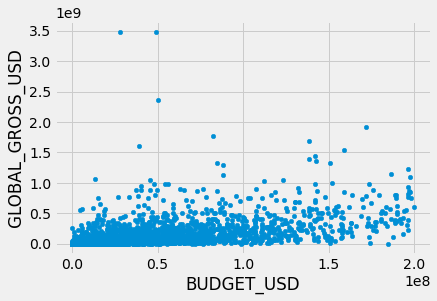

In [16]:
budget_below_200mln.sample(n = 3500, random_state = 1).plot.scatter("BUDGET_USD", "GLOBAL_GROSS_USD");

_`Figure 9. Movie revenue vs budget. (Half of budgets below $200.000.000.)`_

There's a bit of an uptick past about 100.000.000 USD, but the situation is still too crowded to make sense of it with a scatter plot. Another option is to subdivide our budget range into convenient intervals, group together budgets that fall in the same interval, and calculate their average revenue.

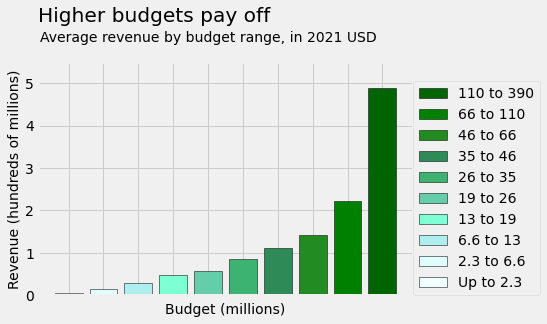

In [17]:
# Subdivide the budget range into ten ranges of roughly the same size (i.e, about the same number of budgets falls in each).
movies_with_budget_and_revenue["BUDGET_RANGE"] = pd.qcut(movies_with_budget_and_revenue["BUDGET_USD"], 10).map(lambda x: x.right).astype(int)
budget_and_revenue_by_range = movies_with_budget_and_revenue.groupby("BUDGET_RANGE")

# Calculate the average revenue for each interval.
mean_revenues =  budget_and_revenue_by_range["GLOBAL_GROSS_USD"].mean()

# We'll draw a bar chart. Calculate the bar locations and set up the colours.
bar_locations = [i for i in range(len(movies_with_budget_and_revenue["BUDGET_RANGE"].unique()))]
bar_colors = ["azure",
              "lightcyan",
              "paleturquoise",
              "aquamarine",
              "mediumaquamarine",
              "mediumseagreen",
              "seagreen",
              "forestgreen",
              "green",
              "darkgreen" ]

# Chart
fig_budget_and_revenue, ax_budget_and_revenue = plt.subplots(1, 1)
budget_and_revenue_bars = ax_budget_and_revenue.bar(x = bar_locations, 
                         height = mean_revenues,
                         edgecolor = "black",
                         tick_label = ["" for i  in bar_locations])

# Colour each bar accordingly.
for patch, color in zip(budget_and_revenue_bars.patches, bar_colors):
    patch.set_facecolor(color)

# Create a legend for the bars semi-manually.
legend_handles = reversed(budget_and_revenue_bars.patches)
legend_labels = ["110 to 390",
                 "66 to 110",
                 "46 to 66",
                 "35 to 46",
                 "26 to 35",
                 "19 to 26",
                 "13 to 19",
                 "6.6 to 13",
                 "2.3 to 6.6",
                 "Up to 2.3"]

ax_budget_and_revenue.legend(legend_handles, legend_labels, loc = (1,0))

# Format the axes.
ax_budget_and_revenue.set_xlabel("Budget (millions)", fontsize = axis_labels_fontsize);
ax_budget_and_revenue.set_ylabel("Revenue (hundreds of millions)", fontsize = axis_labels_fontsize);
yticks = ax_budget_and_revenue.get_yticks()
ax_budget_and_revenue.set_yticks(yticks, [i for i in range(len(yticks))]);
ax_budget_and_revenue.set_ylim(0, 5.5 * (10 ** 8));
ax_budget_and_revenue.set_title("Higher budgets pay off", pad = 40, loc = "left");
ax_budget_and_revenue.text(0.092, 0.98, "Average revenue by budget range, in 2021 USD", transform = fig_avg_budget.transFigure);

_`Figure 10. Average revenue by budget range.`_

The chart leaves no doubt that, on average, the higher the budget, the higher the revenue, especially for very high budgets. This applies only to the subset of movies with budget and revenue information we have available, though, and doesn't take into account the year the movie was released. (Many different factors may influence movie revenues, and it may well be that, for a particular year, movie revenues were low on their own, no matter the budget.)

### Does size matter?

Back in the 90s, about 90-100 minutes were pretty typical lengths for movies. However, one gets the impression that movies have been getting longer in more recent years, so it's fair to wonder whether movie length has been increasing in a consistent fashion over time. In this section, we're going to check that; additionally, we're going to see if longer movies are more expensive (which is reasonable to expect) and whether there's any correlation between the length of a movie and how well it scores.

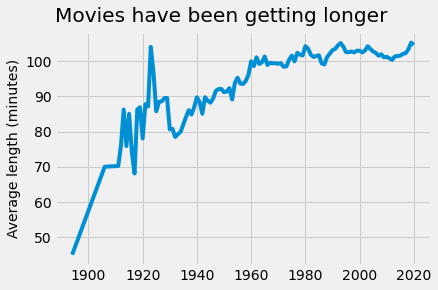

In [18]:
length_data = imdb[["TITLE", "RELEASE_YEAR", "LENGTH_MIN", "WAVG_SCORE", "BUDGET_USD"]]
length_by_year = length_data.groupby("RELEASE_YEAR")

fig_length, ax_length = plt.subplots(1, 1)

ax_length.plot(length_by_year["LENGTH_MIN"].mean());
ax_length.set_ylabel("Average length (minutes)", fontsize = axis_labels_fontsize)
ax_length.set_title("Movies have been getting longer", pad = 10, loc ="left");

_`Figure 11. Average movie length by year.`_

The question of length was easy to settle—quite clearly, **the average movie length has been going up over the years.** The more jagged line up until about the 1930s is likely due to the low number of movies we have for that time frame, although it would be interesting to see what are the outliers of the early 1920s that pushed the average movie length all the way up to present-day levels. 

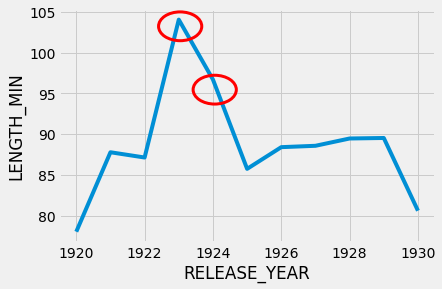

In [21]:
# Let's look for the outlier years.
length_data_20_30 = length_data.query("RELEASE_YEAR >= 1920 and RELEASE_YEAR <= 1930")
length_data_20_30_by_year = length_data_20_30.groupby("RELEASE_YEAR")
fig_length_20_30, ax_length_20_30 = plt.subplots(1, 1)
ax_length_20_30 = length_data_20_30_by_year["LENGTH_MIN"].mean().plot();
ax_length_20_30.set_ylabel("LENGTH_MIN")

# Highlight the outliers.
circle1923 = mpl.patches.Circle((0.36, 0.82), 0.05, fill = False, color = "red", linewidth = 3, transform = fig_length_20_30.transFigure, zorder = 3)
circle1924 = mpl.patches.Circle((0.44, 0.6), 0.05, fill = False, color = "red", linewidth = 3, transform = fig_length_20_30.transFigure, zorder = 3)
ax_length_20_30.add_artist(circle1923)
ax_length_20_30.add_artist(circle1924);

_`Figure 12. Average movie length between 1920 and 1930. The highlights show extreme outliers.`_

From the line chart above, two years stand out in particular: 1923 and 1924. Compared to other years of the decade, they have the highest percentages of movies whose length was above the average of the time, which was about 87 minutes.

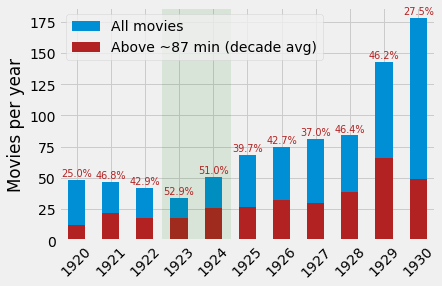

In [22]:
avg_length_20_30 = length_data_20_30["LENGTH_MIN"].mean()

# Movies from 1920-1930 whose length is greater than that decade's average. Grouped by release year.
above_avg_length_20_30_by_year = length_data_20_30.query("LENGTH_MIN > @avg_length_20_30").groupby("RELEASE_YEAR")
above_avg_length_20_30_by_year_pct = (100 * above_avg_length_20_30_by_year.size() / length_data_20_30_by_year.size()).round(1).apply(lambda x: "{}%".format(x))

# Plot movie count between 1920-1930, plus count and percent of movies with length above average.
ax = length_data_20_30_by_year.size().plot.bar(label = "All movies")
above_avg_length_20_30_by_year.size().plot.bar(ax = ax, color = "firebrick", label = "Above ~87 min (decade avg)", ylabel = "Movies per year", xlabel = "", fontsize = axis_labels_fontsize)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Add percentage indicators on top of the bars.
for year in range(1920, 1931):    
    ax.text(year - 1920, length_data_20_30_by_year.size()[year] + 3, above_avg_length_20_30_by_year_pct[year], fontsize = "x-small", ha = "center", color = "firebrick")
    
# Highlight 1923 and 1924.
highlight = plt.Rectangle((2.5, 0), 2, 195, alpha = 0.1, color = "green")
ax.add_patch(highlight)
ax.legend();

_`Figure 13. Percentage of movies of length above each year's average, 1920-1930.`_

Now that we know where to look, let's find the five longest movies from those two years that were above average length.

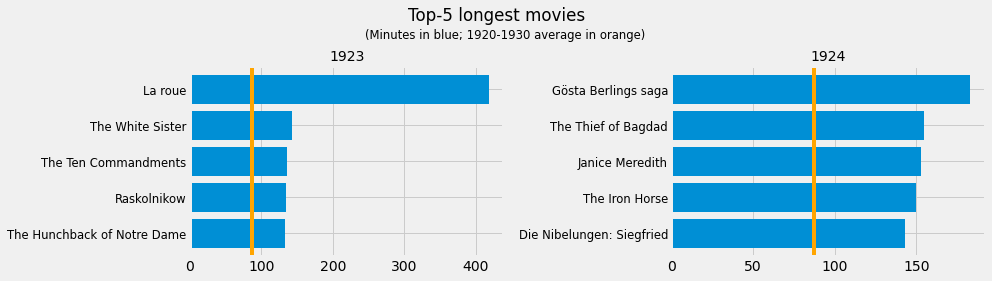

In [23]:
# Top-5 longest movies from 1923 and 1924.
above_avg_1923 = (length_data.query("RELEASE_YEAR == 1923 and LENGTH_MIN > @avg_length_20_30")[["TITLE", "LENGTH_MIN"]]
                  .sort_values("LENGTH_MIN", ascending = False).head() # This makes sure that only the 5 longest are selected...
                  .sort_values("LENGTH_MIN", ascending = True)) # ... while this makes sure they'll be plotted longest-to-shortest from top-to-bottom.
                  
above_avg_1924 = (length_data.query("RELEASE_YEAR == 1924 and LENGTH_MIN > @avg_length_20_30")[["TITLE", "LENGTH_MIN"]]
                  .sort_values("LENGTH_MIN", ascending = False).head()
                  .sort_values("LENGTH_MIN", ascending = True))

# Draw the barh chart.
fig_5_longest, (ax_1923_5_longest, ax_1924_5_longest) = plt.subplots(1, 2, figsize = (14, 4))

bar_locations = [0, 1, 2, 3, 4]

# 1923 top-5 longest.
ax_1923_5_longest.barh(bar_locations, above_avg_1923["LENGTH_MIN"])
ax_1923_5_longest.set_yticks(bar_locations)
ax_1923_5_longest.set_yticklabels(above_avg_1923["TITLE"], fontsize = "small");
ax_1923_5_longest.axvline(avg_length_20_30, color = "orange")
ax_1923_5_longest.set_title("1923", fontsize = "medium")

# 1924 top-5 longest.
bar_for_legend = ax_1924_5_longest.barh(bar_locations, above_avg_1924["LENGTH_MIN"])
ax_1924_5_longest.set_yticks(bar_locations)
ax_1924_5_longest.set_yticklabels(above_avg_1924["TITLE"], fontsize = "small");
ax_1924_5_longest.axvline(avg_length_20_30, color = "orange")
ax_1924_5_longest.set_title("1924", fontsize = "medium")

fig_5_longest.suptitle("Top-5 longest movies")
fig_5_longest.text(0.37, 0.87,"(Minutes in blue; 1920-1930 average in orange)", fontsize = "small")
fig_5_longest.tight_layout()

_`Figure 14. Length of top-5 longest movies from 1923 and 1924.`_

With a bit of a stretch, you could say that, in 1924, the top-5 longest movies were fairly comparable both in length and in how much longer than average they were; **in 1923, the longest movie was about three times longer than the other four in the top-5!**

Next, we can have a look at any possible correlation between movie length and movie budget. Intuitively, we expect a strong positive correlation: the longer the movie, the higher its cost and thus its budget should be.

In [24]:
length_budget_corr = length_data["LENGTH_MIN"].corr(length_data["BUDGET_USD"])
print("Pearson correlation between length and budget: ", length_budget_corr)

Pearson correlation between length and budget:  0.4276433414377679


Instead, the correlation between the two is weak-ish—certainly weaker than I was expecting. If we look at a scatter plot over all movies, we see that up to some point between 150 and 200 minutes, budgets _do_ tend to increase with movie length; however, past that point, budget size decreases again, being relatively low for some length outliers. (Movies with no budget information are not shown.)

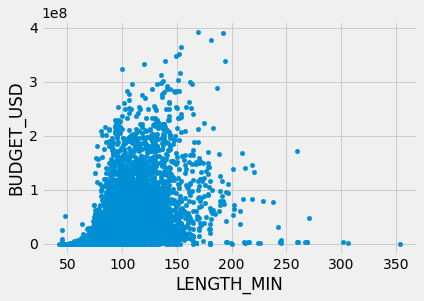

In [25]:
length_data.plot.scatter("LENGTH_MIN", "BUDGET_USD");

_`Figure 15. Movie budget vs movie length.`_

It makes sense to see whether budgets increase _on average_ with movie length. Let's categorise each movie based on its duration as follows:

- `Up to 1 hr`
- `1-2 hr`
- `2-3 hr`
- `3-4 hr`
- `Over 4 hr`

Unfortunately, this categorisation will produce rather different category sizes, but it's better than the alternative. Categories with comparable numbers of movies, as we would get using `pandas.qcut`, tend to include movies with length ranges that are either too short (such as 86-93 minutes) or too long (112-808 minutes!).

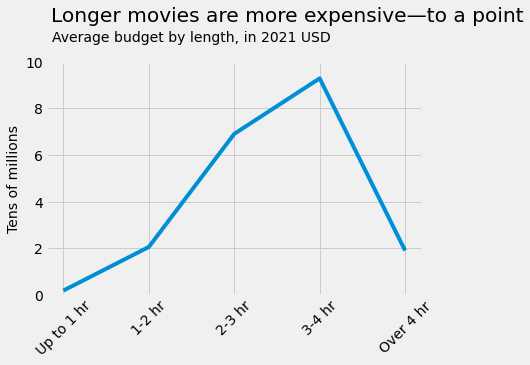

In [26]:
length_data_by_length_category = length_data[["LENGTH_MIN", "BUDGET_USD"]].copy()

def length_category(length):
    if length <= 60: return "Up to 1 hr"
    if 60 < length <= 120: return "1-2 hr"
    if 120 < length <= 180: return "2-3 hr"
    if 180 < length <= 240: return "3-4 hr"
    if 240 < length: return "Over 4 hr"

# Assign each movie to its length category, and then group by it.
length_data_by_length_category["LENGTH_CAT"] = length_data_by_length_category["LENGTH_MIN"].map(length_category)
length_data_by_length_category = length_data_by_length_category.groupby("LENGTH_CAT")

# This will help us sort categories correctly more easily.
categories_sorted_asc = ["Up to 1 hr", "1-2 hr", "2-3 hr", "3-4 hr", "Over 4 hr"]

budget_by_length_category = length_data_by_length_category["BUDGET_USD"].mean().reindex(categories_sorted_asc)

# Draw plot.
fig_length_and_budget, ax_length_and_budget = plt.subplots(1, 1)
ax_length_and_budget.plot(budget_by_length_category)

#Format the axes.
ax_length_and_budget.set_ylabel("Tens of millions", fontsize = axis_labels_fontsize)
yticks = ax_length_and_budget.get_yticks()
ax_length_and_budget.set_yticks(yticks, [-2, 0, 2, 4, 6, 8, 10]) # Matplotlib is VERY weird when it comes to ticks...
ax_length_and_budget.set_ylim(0, 10**8);

for tick in ax_length_and_budget.get_xticklabels():
    tick.set_rotation(45)
    
ax_length_and_budget.set_title("Longer movies are more expensive—to a point", pad = 40, x = 0.64)
ax_length_and_budget.text(0.092, 0.95, "Average budget by length, in 2021 USD", transform = fig_length_and_budget.transFigure);

_`Figure 16. Average movie budget by length category.`_

The chart above seems to confirm what the scatterplot said: up to around 4 hours, the longer the movie, the higher the budget; however, the steepness of the line decreases with movie length, which means that **budget increases become more and more modest as the length of the movie goes up.** After the 4-hour mark, budgets drop.

Finally, we can see if the length of a movie and how high it scores are correlated in any way. Intuitively, we should expect they don't.

In [27]:
length_score_corr = length_data["LENGTH_MIN"].corr(length_data["WAVG_SCORE"])
print("Pearson correlation between length and WAVG_SCORE: ", length_score_corr)

Pearson correlation between length and WAVG_SCORE:  0.2424324845708058


The Pearson coefficient is low enough that there's basically no (linear) relationship between the two variables, as shown by the scatterplot below: **within the 200-minute mark, virtually all possible scores are attained many, many times.** However, after the 400-minute mark, movies do tend to score fairly high. Still, these are exceptions, as movies that long are extremely rare, and are probably works of art whose high score is unlikely to depend on their length.

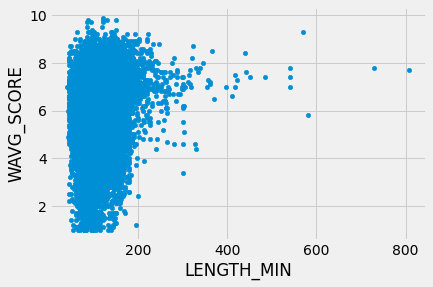

In [28]:
length_data.plot.scatter("LENGTH_MIN", "WAVG_SCORE");

_`Figure 18. Average movie score vs. movie length.`_

### IMDB scores inside out

Let's start with an overview of the movie scores on IMDB. What does the `WAVG_SCORE` distribution look like?

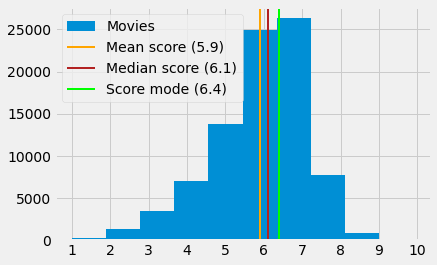

In [29]:
mean_score = imdb["WAVG_SCORE"].mean().round(1)
median_score = imdb["WAVG_SCORE"].median().round(1)
score_mode = imdb["WAVG_SCORE"].mode()[0].round(1)

score_dist = imdb["WAVG_SCORE"].hist( label = "Movies")
score_dist.locator_params(axis = "x", nbins = 10)
score_dist.axvline(mean_score, color = "orange", label = "Mean score ({})".format(mean_score), linewidth = 2)
score_dist.axvline(median_score, color = "firebrick", label = "Median score ({})".format(median_score), linewidth = 2)
score_dist.axvline(score_mode, color = "lime", label = "Score mode ({})".format(score_mode), linewidth = 2)
score_dist.legend();

_`Figure 19. Distribution of movies in the dataset by their average IMDB score.`_

The distribution is fairly left-skewed. On average, the `WAVG_SCORE` of a movie on IMDB is 5.9; the median is barely above that at 6.1, while the most frequent `WAVG_SCORE` is 6.4. This means around 25,000 movies on IMDB are considered to be about average, in that their score gravitates around the average score across the entire dataset. Slightly more movies could be defined as "good", that is with an average score between about 6.5 and 7. Very good movies are more rare: the number of movies drops dramatically when the score is just above 7, and truly outstanding movies, scoring above 8, are extremely rare.

Another interesting, generic question we can ask ourselves is: **do older movies score worse or better than modern movies?** That's easy to see.

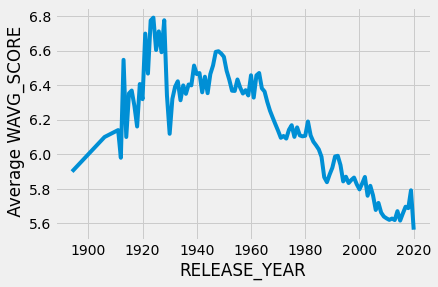

In [31]:
imdb[["RELEASE_YEAR", "WAVG_SCORE"]].groupby("RELEASE_YEAR")["WAVG_SCORE"].mean().plot();
plt.ylabel(" Average WAVG_SCORE");

_`Figure 20. Average movie score by year.`_

On average, movie scores seem to be plummeting with time. **Let's keep in mind, however, that this does not reflect how "picky" viewers from different times may be:** IMDB was not around [before 1990](https://www.britannica.com/topic/IMDb), so what we're seeing here is how modern viewers rate movies from different years, and it appears that, on average, they rate older movies more highly. This may be for a variety of reasons: it might be that there are only few titles for older years and they all happen to be rated fairly highly; it might be that only movie _connaisseurs_ watch and rate older movies, and they may be more likely to rate them highly than the average modern viewer; or, it might be that older movies were actually better according to the average viewer.

#### Scores and budgets

Moving on to more specific questions, we can try to see whether throwing more money at a movie increases its chances of being successful. In more formal terms: **do higher budgets correlate with higher scores?** We can start by looking at the Pearson correlation coefficient.

In [32]:
budget_score_corr = imdb["BUDGET_USD"].corr(imdb["WAVG_SCORE"])
print("Pearson correlation between BUDGET_USD and WAVG_SCORE: ", budget_score_corr)

Pearson correlation between BUDGET_USD and WAVG_SCORE:  0.28402951902765533


It looks like any correlation, if at all present, is very weak. The scatter plot below, however, seems to suggest that rather than a _linear_ correlation, measured by the Pearson coefficient, the two variables might have a _logarithmic_ correlation: `WAVG_SCORE` does increase with `BUDGET_USD`, but the increase becomes less and less important with larger budgets. (At a point, this must happen anyway, because the `WAVG_SCORE` can't be more than 10.)

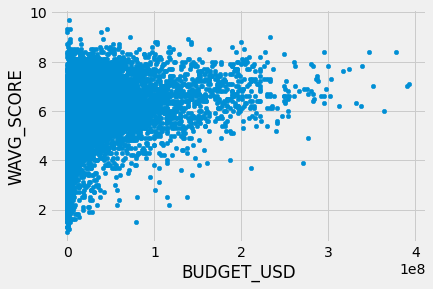

In [33]:
imdb.plot.scatter("BUDGET_USD", "WAVG_SCORE");

_`Figure 21. Average score vs budget.`_

At a glance, most movies have budgets up to \\$100.000.000, yet their score range is rather dense and wide, spanning from the minimum all the way to the maximum. Most of the data points representing movies with budget up to a hundred million dollars cluster around score 6, suggesting that decent—and even very good—movies can be produced even with a relatively modest budget.

Movies with a budget larger than \\$100.000.000 are more rare, but they're also less likely to score below 5. Movies with extremely high budgets don't really break through the ceiling of score 8 to any significant extent; movies with more modest budgets do that much more often, but of course, lower-budget movies are vastly more common, so, statistically speaking, this is to be expected. 

As we did before for different variables, we can group movies into budget groups, calculate the average score for each group, and see how this average varies.

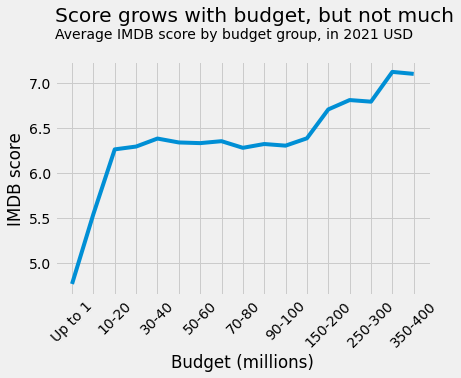

In [34]:
budget_and_score = imdb.loc[imdb["BUDGET_USD"].notnull(), ["BUDGET_USD", "WAVG_SCORE"]].copy()

def assign_budget_group(value):
    """Returns the budget group that `value` belongs to."""
    if value <= 1000000:
        return "Up to 1"
    if 1000000 < value <= 10000000:
        return "1-10"        
    for k in range(10, 100, 10):
        if k * 1000000 < value <= (k + 10) * 1000000:
            return "{}-{}".format(k, k + 10)
    for k in range(100, 400, 50):
        if k * 1000000 < value <= (k + 50) * 1000000:
            return "{}-{}".format(k, k + 50)

# This will allow us to reindex the data for the chart and choose xtick labels more easily.
budget_group_index = (["Up to 1", 
                     "1-10"] +
                     ["{}-{}".format(k, k + 10) for k in range(10, 100, 10)] +
                     ["{}-{}".format(k, k + 50) for k in range(100, 400, 50)])
            
budget_and_score["BUDGET_GROUP"] = budget_and_score["BUDGET_USD"].map(assign_budget_group)
budget_and_score_by_budget_group = budget_and_score.groupby("BUDGET_GROUP")
avg_score_by_budget_group = budget_and_score_by_budget_group["WAVG_SCORE"].mean().reindex(budget_group_index)

# Chart
fig_score_by_budget_group, ax_score_by_budget_group = plt.subplots(1, 1)
ax_score_by_budget_group.plot(avg_score_by_budget_group)

# Format the axes.
ax_score_by_budget_group.set_xlabel("Budget (millions)");
ax_score_by_budget_group.set_ylabel("IMDB score");

# Display only every other xtick label.
xticks = ax_score_by_budget_group.get_xticks()
xtick_labels = budget_group_index.copy()
for i in range(len(budget_group_index)):
    if i % 2 == 1:
        xtick_labels[i] = ""
ax_score_by_budget_group.set_xticks(xticks, xtick_labels, rotation = 45);

ax_score_by_budget_group.set_title("Score grows with budget, but not much", pad = 40, loc = "left");
ax_score_by_budget_group.text(0.08, 0.96, "Average IMDB score by budget group, in 2021 USD", transform = fig_score_by_budget_group.transFigure);

_`Figure 22. Average score by budget group.`_

As the scatter plot in `Figure 21` suggested, the average IMDB score does grow with budget size, but the growth is indeed logarithmic-looking: faster at first, slower later on. This suggests that, **after a certain point, more money won't necessarily make the movie better**; not everything about movie quality depends on how much you can spend on it.

#### Scores and revenue

The next question we can tackle is whether a higher score correlates with a higher revenue, which seems reasonable to expect: the higher a movie is rated, the more the people that will likely be willing to pay to see it. As usual, let's first get a sense for it by checking the Pearson coefficient and a scatter plot.

In [35]:
revenue_and_score_corr = imdb["WAVG_SCORE"].corr(imdb["GLOBAL_GROSS_USD"])
print("Pearson correlation between WAVG_SCORE and GLOBAL_GROSS_USD: ", revenue_and_score_corr)

Pearson correlation between WAVG_SCORE and GLOBAL_GROSS_USD:  0.1534303514278638


The value above suggests no linear correlation, though the two variables might be correlated in some other way.

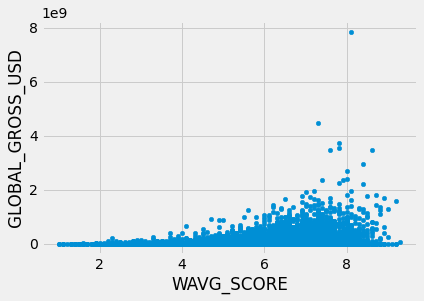

In [36]:
imdb.plot.scatter("WAVG_SCORE","GLOBAL_GROSS_USD");

_`Figure 23. Movie revenue vs. average score.`_

There is certainly no shortage of movies that didn't gross a lot despite scoring very high. However, it does look like that revenue increases with score—slower at first, then faster and faster until about score 7.5, when the revenue slightly decreases again. By grouping movies by scores, we can see if this trends holds true on average.

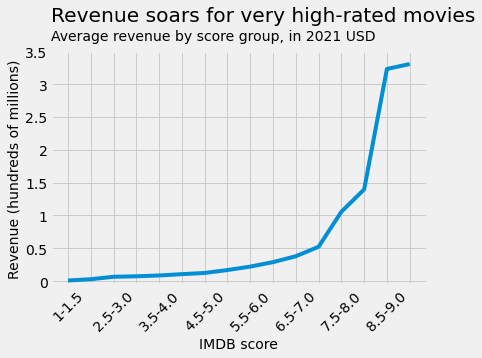

In [37]:
revenue_and_score =imdb.loc[imdb["GLOBAL_GROSS_USD"].notnull(), ["GLOBAL_GROSS_USD", "WAVG_SCORE"]].copy()

def assign_score_group(score):
    """Returns the score group that `score` belongs to."""
    score_steps = [1, 1.5, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5]
    for s in score_steps:
        if s < score <= s + 0.5: return "{}-{}".format(s, s + 0.5)    

revenue_and_score["SCORE_GROUP"] = revenue_and_score["WAVG_SCORE"].map(assign_score_group)
revenue_and_score_by_score_group = revenue_and_score.groupby("SCORE_GROUP")
avg_revenue_by_score_group = revenue_and_score_by_score_group["GLOBAL_GROSS_USD"].mean()

# Chart
fig_revenue_by_score_group, ax_revenue_by_score_group = plt.subplots(1, 1)
ax_revenue_by_score_group.plot(avg_revenue_by_score_group)

# Format the axes.
ax_revenue_by_score_group.set_xlabel("IMDB score", fontsize = axis_labels_fontsize);
ax_revenue_by_score_group.set_ylabel("Revenue (hundreds of millions)", fontsize = axis_labels_fontsize);

# Display only every other xtick label.
xticks = ax_revenue_by_score_group.get_xticks()
xtick_labels = avg_revenue_by_score_group.index.to_list()
for i in range(len(xtick_labels)):
    if i % 2 == 1:
        xtick_labels[i] = ""
ax_revenue_by_score_group.set_xticks(xticks, xtick_labels, rotation = 45);
        
# Change ytick labels to be more readable.
yticks = ax_revenue_by_score_group.get_yticks()
ytick_labels = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
ax_revenue_by_score_group.set_yticks(yticks, ytick_labels)         
ax_revenue_by_score_group.set_ylim(-0.5 * 10**7, 3.5*10**8)

ax_revenue_by_score_group.set_title("Revenue soars for very high-rated movies", pad = 30, loc = "left");
ax_revenue_by_score_group.text(0.08, 0.92, "Average revenue by score group, in 2021 USD", transform = fig_revenue_by_score_group.transFigure);

_`Figure 24. Average revenue by score group.`_

In general, the trend seems confirmed; however, we need to keep in mind that among movies that scored 7 or higher, there are a few outliers that happen to have high-to-very-high revenues, and if we excluded them, the curve wouldn't rise quite so steeply.

#### Average movie score by country

It would be interesting to find out what's the average rating for movies of each given country; before we can do that, we need to extract a list of unique countries from our dataset. In some cases, a movie was produced by more than one country, and the value of the `COUNTRY` column for that movie will be list-like, e.g. `France, Spain`. To get our list of unique countries, we can make each entry into an actual list, and then `explode` the `COUNTRY` column. Note that the country of origin of a movie isn't always known, in which case the `COUNTRY` column reads `(Missing)`. We're not interested in those records, so we'll filter them out first.

In [38]:
countries_and_scores = imdb.loc[imdb["COUNTRY"]!= "(Missing)", ["COUNTRY", "WAVG_SCORE", "VOTES", "RELEASE_YEAR"]].copy()
countries_and_scores["COUNTRY"] = countries_and_scores["COUNTRY"].str.split(",")
countries_and_scores = countries_and_scores.explode("COUNTRY")

# Make sure there are no extra spaces in the country names as a result of the explosion.
countries_and_scores["COUNTRY"] = countries_and_scores["COUNTRY"].str.strip()
unique_countries = list(countries_and_scores["COUNTRY"].unique())

The next step is to create a dataframe indexed with our list of unique countries, for each of which we'll compute the average movie score and add it to the dataframe. (Note that this value will be the average of `WAVG_SCORE` across all the movies that come from a certain country, and so it will be an average of averages, as the `WAVG_SCORE` of each movie is itself an average of all the scores the movie received.) To get an idea of the reliability of this average, we'll also keep track of how many movies there are for each country and the average number of votes per movie, calculated as the total number of votes for all movies of a given country divided by the total number of movies from that country.

Note that a single movie may be counted more than once: for example, if a movie was a joint collaboration between the US and the UK, it would increase by 1 the movie count for both countries. This means that the total of the `MOVIES` column of the dataframe below is larger than the total number of rows in the original IMDB dataframe, and that's not a mistake.

In [39]:
avg_score_by_country = pd.DataFrame()

for country in unique_countries:
    country_scores_and_votes = countries_and_scores.query("COUNTRY == @country")[["WAVG_SCORE", "VOTES"]]
    country_avg_score = country_scores_and_votes["WAVG_SCORE"].mean()
    country_avg_votes_per_movie = country_scores_and_votes["VOTES"].mean()
    avg_score_by_country.at[country, "AVG_WAVG_SCORE"] = country_avg_score # This is the average of averages, hence the name AVG_WAVG_SCORE
    avg_score_by_country.at[country, "MOVIES"] = len(country_scores_and_votes)
    avg_score_by_country.at[country, "AVG_VOTES_PER_MOVIE"] = country_avg_votes_per_movie

avg_score_by_country.sort_values("AVG_WAVG_SCORE", ascending = False).head(10)

,AVG_WAVG_SCORE,MOVIES,AVG_VOTES_PER_MOVIE
Libya,8.300000,2.0,28332.000000
Malawi,7.600000,1.0,24574.000000
Moldova,7.500000,6.0,469.166667
Azerbaijan,7.228000,25.0,408.080000
Sri Lanka,7.180000,40.0,572.675000
Bangladesh,7.159829,117.0,1028.735043
Uganda,7.125000,4.0,1923.750000
Soviet Union,7.101501,866.0,1304.414550
Vatican City,7.100000,1.0,369.000000
Botswana,7.100000,2.0,33656.500000


_`Table 2. Top-10 countries by average score of their movies.`_

Most of the 10 top-scoring countries in the list above aren't exactly the first that come to mind when you think of famous or very good movies. This doesn't mean that they *can't* produce good movies, but for most of them, we only know about a handful of movies they've produced, which is not enough to tell how good movies from those countries may be on average. We need to choose a cut-off point, a minimum number of movies that a country must have for us to consider it.

In [40]:
avg_score_by_country["MOVIES"].describe()

count      194.000000
mean       560.731959
std       2679.149527
min          1.000000
25%          3.000000
50%         21.000000
75%        224.750000
max      34325.000000
Name: MOVIES, dtype: float64

Up to 50% of all countries have far too few movies—21 at most. This is admittedly rather arbitrary, but let's choose as the cut-off point the 75% mark, that is only countries with more than 224 movies on record.

In [41]:
avg_score_by_country = avg_score_by_country.query("MOVIES > 224").sort_values("AVG_WAVG_SCORE", ascending = False)
avg_score_by_country.head(10)

,AVG_WAVG_SCORE,MOVIES,AVG_VOTES_PER_MOVIE
Soviet Union,7.101501,866.0,1304.414550
Czechoslovakia,7.043450,313.0,1981.009585
Yugoslavia,6.764304,395.0,911.222785
Romania,6.588032,493.0,3880.267748
Bulgaria,6.575000,272.0,10796.169118
Japan,6.485977,3701.0,7635.647122
Indonesia,6.344681,282.0,2100.028369
South Korea,6.333949,1299.0,3791.516551
Hungary,6.325078,642.0,7892.133956
Switzerland,6.275943,636.0,5633.526730


_`Table 3. Top-10 countries by average score of their movies. (Only countries with 224 or more movies.)`_

The list we got is a bit "better": there are much many more movies per country, and the average number of votes per movie is decent too. Still, intuitively one would probably expect to see the USA somewhere among the top-10, yet it's not there. Where is it?

In [42]:
avg_score_by_country.tail()

,AVG_WAVG_SCORE,MOVIES,AVG_VOTES_PER_MOVIE
Australia,5.760288,1181.0,18036.675699
Russia,5.738689,1083.0,2204.931671
USA,5.609413,34325.0,19991.676562
Canada,5.567412,3621.0,16523.417012
South Africa,5.564545,330.0,12588.496970


_`Table 4. Bottom-5 countries by average score of their movies. (Only countries with 224 or more movies.)`_

Nearly at the bottom, with a rather mediocre score. We can compare the distribution of IMDB average scores for the USA (and other countries) against that of the world using the function below.

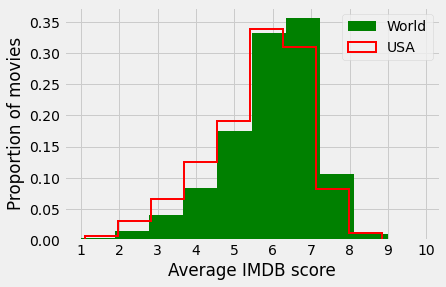

In [43]:
def score_dist_comparison(country):
    """Creates a chart comparing the distribution of movies from `country` against the distribution of movies of all countries. 
    the comparison is done through two histograms showing the proportion of movies whose `WAVG_SCORE` is within a given range, eg 6-7."""
    
    country_avg_scores = countries_and_scores.query("COUNTRY == @country")["WAVG_SCORE"]
    world_avg_scores = countries_and_scores["WAVG_SCORE"]

    fig_country_vs_world, ax_country_vs_world = plt.subplots(1, 1)

    ax_country_vs_world.hist(world_avg_scores, density = True, color = "green", label = "World")
    ax_country_vs_world.hist(country_avg_scores, density = True, color = "red", linewidth = 2, histtype = "step", label = country)
    ax_country_vs_world.locator_params(axis = "x", nbins = 10)
    ax_country_vs_world.legend()    
    ax_country_vs_world.set_xlabel("Average IMDB score")
    ax_country_vs_world.set_ylabel("Proportion of movies")
    
# Let's look at what the score distribution looks like for the USA.
score_dist_comparison("USA")

_`Figure 25. Proportion of movies across the average score range, USA vs. world.`_

Compared to the entire world, it seems the USA has a higher percentage of "bad" scores, i.e. below 6, and a lower percentage of scores above 6. Compare this with movies from the Soviet Union, which is at the top of our list:

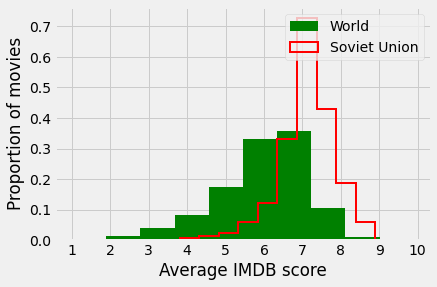

In [44]:
score_dist_comparison("Soviet Union")

_`Figure 26. Proportion of movies across the average score range, URSS vs. world.`_

The distribution is _dramatically_ different from that of the entire world, with over 70% of Soviet Union movies scoring on average around 7, and nearly 20% around 8. It may well be that Soviet Union movies are just that good, though the stark difference from the world distribution is a little suspect. A possible explanation may lie in _who_ watches these movies. For example, if they were only available in Russian without subtitles, it's possible that they're watched mostly by Russian people, who might rate them more highly than other people would because they can relate to them more.

If this were true, the fact that movies from _Russia_, instead, are at the bottom of the list just above the USA might seem a bit of a puzzle; it could be explained by the fact that Russia (as in, the modern Russian Federation) came to be in 1991, after the Soviet Union collapsed, so Russian movies are more recent and perhaps more likely to have reached a wider audience. It's also possible that country data might be mixed up and therefore causing errors: for example, the dataset contains movies from the Soviet Union released _after_ its collapse, and movies from Russia from well before it was created:

In [45]:
print("Newest Soviet Union movie on record from: ", countries_and_scores.query("COUNTRY == 'Soviet Union'")["RELEASE_YEAR"].max())
print("Oldest Russian movie on record from: ", countries_and_scores.query("COUNTRY == 'Russia'")["RELEASE_YEAR"].min())

Newest Soviet Union movie on record from:  1995
Oldest Russian movie on record from:  1911


In any case, checking whether there is any "country bias" in the votes is not possible, because the dataset doesn't contain very granular location data. (The original dataset only categorised voters as being either located in the US or not.)

#### Influence of voter sex and movie genre on scores

It's natural to wonder which movie genres rank the highest on IMDB. To figure it out, we can use the same "exploding" technique we used to check average scores by country.

In [46]:
genres_and_scores = imdb[["GENRE"] + list(imdb.columns[8:])].copy() # Columns from 8 till the end are votes and average scores by sex and age.
genres_and_scores["GENRE"] = genres_and_scores["GENRE"].str.split(",")
genres_and_scores = genres_and_scores.explode("GENRE")

# Make sure there are no extra spaces in the genre names as a result of the explosion.
genres_and_scores["GENRE"] = genres_and_scores["GENRE"].str.strip()
unique_genres = list(genres_and_scores["GENRE"].unique())

avg_score_by_genre = pd.DataFrame()

for genre in unique_genres:
    genre_movies = genres_and_scores.query("GENRE == @genre")
    genre_averages = genre_movies.mean(numeric_only = True)        
    genre_avg_score = genre_averages["WAVG_SCORE"]
    for col in genre_averages.index:
        avg_score_by_genre.at[genre, col] = genre_averages[col]        
    avg_score_by_genre.at[genre, "MOVIES"] = len(genre_movies)   

# Let's add a column that shows the difference between the average score for each genre between male and female voters.
avg_score_by_genre["M_F_DIFF"] = avg_score_by_genre["M_AVG_SCORE"] - avg_score_by_genre["F_AVG_SCORE"]
 
avg_score_by_genre.rename(columns = {"WAVG_SCORE": "AVG_WAVG_SCORE"}, inplace = True)
avg_score_by_genre = avg_score_by_genre.sort_values("AVG_WAVG_SCORE", ascending = False)
avg_score_by_genre[["AVG_WAVG_SCORE", "MOVIES"]]

,AVG_WAVG_SCORE,MOVIES
Documentary,7.300000,2.0
Film noir,6.644042,663.0
Biography,6.624022,2377.0
History,6.543380,2296.0
War,6.427520,2242.0
News,6.400000,1.0
Animation,6.381317,2141.0
Musical,6.247379,2041.0
Music,6.243635,1689.0
Drama,6.235876,47110.0


_`Table 5. Movie genre by average score.`_

Just like before, some scores don't necessarily describe the overall quality of their respective genre, because they were calculated basing on too few movies. Only 25% of all genre scores are based on less than 1583 movies, so let's restrict ourselves to genres with at least that many movies on record.

In [47]:
avg_score_by_genre["MOVIES"].describe()

count       25.000000
mean      7034.680000
std      10636.413806
min          1.000000
25%       1583.000000
50%       2377.000000
75%       9557.000000
max      47110.000000
Name: MOVIES, dtype: float64

In [48]:
avg_score_by_genre = avg_score_by_genre.query("MOVIES >= 1583").sort_values("AVG_WAVG_SCORE", ascending = False)
avg_score_by_genre[["AVG_WAVG_SCORE", "MOVIES"]]

,AVG_WAVG_SCORE,MOVIES
Biography,6.624022,2377.0
History,6.543380,2296.0
War,6.427520,2242.0
Animation,6.381317,2141.0
Musical,6.247379,2041.0
Music,6.243635,1689.0
Drama,6.235876,47110.0
Romance,6.139687,14128.0
Crime,6.026656,11067.0
Western,5.978395,1583.0


_`Table 6. Movie genre by average score. (Only genres with at least 1583 movies.)`_

None of the genres appear to be outstanding. The top-scoring half scores about average, and from there it's pretty much all downhill. However, it should be noted that these scores aren't representative of "pure" genres, because many of the movies in the dataset were tagged with several genres, so that, for example, the score of the same individual movie may have influenced both the overall `Thriller` and `Sci-Fi` scores. Regardless, according to the IMDB userbase, it seems the best three movie genres out there are biography, history, and war.

This per se isn't particularly interesting, but any difference in scoring between male and female voters might be. **Does the same list look any different in terms of score, if we break it down by sex?**

In [49]:
avg_score_by_genre[["AVG_WAVG_SCORE", "M_AVG_SCORE", "F_AVG_SCORE", "M_F_DIFF"]]

,AVG_WAVG_SCORE,M_AVG_SCORE,F_AVG_SCORE,M_F_DIFF
Biography,6.624022,6.551788,6.777745,-0.225957
History,6.543380,6.477308,6.650370,-0.173062
War,6.427520,6.380999,6.567337,-0.186338
Animation,6.381317,6.274451,6.594208,-0.319757
Musical,6.247379,6.124792,6.415728,-0.290936
Music,6.243635,6.143162,6.470041,-0.326880
Drama,6.235876,6.158796,6.362313,-0.203518
Romance,6.139687,6.049129,6.263150,-0.214020
Crime,6.026656,5.973416,6.121458,-0.148041
Western,5.978395,5.942009,6.097847,-0.155838


_`Table 7. Movie genre by average score and average score by sex. (Only genres with at least 1583 movies.)`_

The columns `M_AVG_SCORE` and `F_AVG_SCORE` show the average score across all movies of each genre by voter sex; the values in the `M_F_DIFF` column have been calculated as `M_AVG_SCORE` minus `F_AVG_SCORE`. These differences are all fairly small, each being less than half a point, but they're all negative, which means that **on average, male voters scored each and every movie genre lower than female voters did.** This is true also of the genres we excluded because of their low movie count. With the data we have, it's difficult to even speculate as to why female voters seem to be ever so slightly more generous than males, but the fact they're _consistently_ so across all movie genres is interesting.

The histograms below show the proportion of movies whose average score was 1, 2, etc, by sex. **The proportion of average "bad" scores (1-5) from female voters is nearly always lower than for males; vice-versa, the proportion of average "good" scores (6-10) from females is higher.** For example, male users gave an average score between 7 and 8 to about 8% of the movies they rated; female users gave the same average score to 15% of the movies they rated!

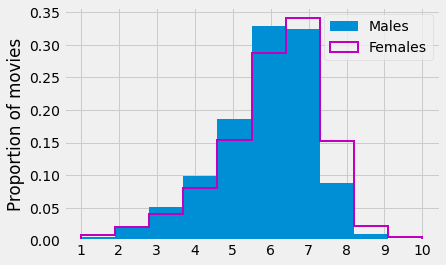

In [50]:
fig_sex_score_diff, ax_sex_score_diff = plt.subplots(1, 1)

ax_sex_score_diff.hist(imdb["M_AVG_SCORE"], density = True, label = "Males")
ax_sex_score_diff.hist(imdb["F_AVG_SCORE"], density = True, label = "Females", histtype = "step", color = "m", linewidth = 2)
ax_sex_score_diff.set_ylabel("Proportion of movies")
ax_sex_score_diff.locator_params(axis = "x", nbins = 10)
ax_sex_score_diff.legend();

_`Figure 27. Proportion of movies by average score assigned by male (blue) and female (purple) voters.`_

The above is a broad overview that doesn't take into account voter age. It would be interesting to see if this phenomenon changes in any way when age cohort is considered. Doing so across all movie genres is beyond the scope of this project, but to conclude this exploration, we can calculate how the average male and female scores change overall with age.

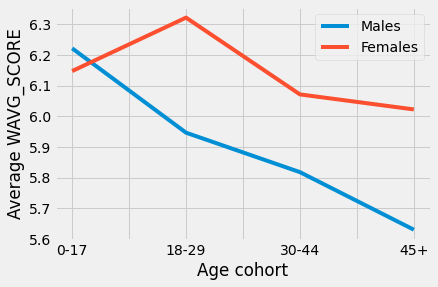

In [52]:
cohorts = ["0-17", "18-29", "30-44", "45+"]
m_f_avg_score_by_age = pd.DataFrame(index = cohorts)

for cohort in cohorts:
    cohort_name = cohort.replace("-", "").replace("+", "PLUS")
    m_f_avg_score_by_age.at[cohort, "Males"] = imdb["M_" + cohort_name + "_AVG_SCORE"].mean()
    m_f_avg_score_by_age.at[cohort, "Females"] = imdb["F_" + cohort_name + "_AVG_SCORE"].mean()
    
m_f_avg_score_by_age.plot()
plt.xlabel("Age cohort")
plt.ylabel("Average WAVG_SCORE");

_`Figure 28. Average IMDB score by age cohort and sex.`_

According to the chart above, **the average score given by a cohort of people of either sex to any movie, regardless of its genre or anything else, decreses as the cohort's age increases.** For example, we see that, on average, female IMDB voters between the ages of 18 and 29 rate movies just above 6.3; the same rating drops to less than 6.1 for female voters aged 30 to 44, and it drops even further for the next cohort.

This chart too suggests that females are slightly more generous when scoring movies than males are, and on top of that, males become more critical than females do with age. For some reason, the females younger than 17 appear a bit more critical than males of the same age range, but the difference is minimal and doesn't negate the overall trends observed.

## Conclusions

During this quick exploration of a dataset of nearly 90000 movies, we tried to answer a few questions about movie budgets, revenues, length, and scores. We found out that:

- on average, **budgets have slowly but fairly steadily grown** from the early 1900s to 2020;

- if a few outliers from the 1940s are excluded, on average **revenues grew slowly from the early 1900s to about 1980,** when they began to slowly taper off. However, when looking at the median revenue, we saw that it was a fairly flat line throughout the entire century, barring the aforementioned outliers and **a prominent peak around the 1980s that took about 20 years to disappear**. We saw that, indeed, movies from the 1976-2000 time frame often grossed much more than movies in 1945-1975 and 2001-2020;

- on average, **movies with higher budgets gross more**, which seems to be especially true in the case of very large budgets;

- **the average movie has become longer and longer over the past century**, from about 55 minutes in 1900 to over an hour and half in 2020. **Longer movies are more expensive on average**, with the average budget growing up to almost 100 million USD for movies in the 3 to 4 hours range. Movies longer than four hours are rather rare, but their budget is closer to 20 million USD on average;

- **IMDB users rate older movies more highly than newer ones on average**. Movies from the 1930s score around 6.8 on average, but from there, the average rating plummets all the way down to 5.6 for movies from 2020;

- **Higher budgets show a very weak correlation with higher scores.** In particular, between 10 and 100 million USD, budgets don't seem to make much of a difference in terms of score, which gravitates around 6.3. With higher budgets, the average score reaches up to 7 points;

- **The revenue range for movies scoring up to 7 points is on average fairly narrow,** up to 50.000.000 USD. From that point on, there's a rather steep growth that takes the average revenue all the way up to over 300 million USD for movies scoring around 9. We shouldn't forget, however, that the presence of few high-scoring, very high-grossing outliers skews this average upward;

- **Very few western countries are among the top-10 in terms of movie scores.** Somewhat surprisingly, Soviet Union movies have an average score of about 7.1 and are at the top of the list, while the United States are almost at the very bottom of the list of all countries, with a meagre average score of 5.6. It might be that, in the cases of some countries, the location of the voters influences the scores in a way or another (for example, if most voters of a certain movie all come from the same country that produced the movie), but this is not something we could verify because this kind of information was simply not available in the dataset;

- **On average, female voters score _every_ movie genre higher than male voters.** The difference is small but present for all genres, which suggests that male voters might be more "picky," and that they grow more so with age. On average, a movie scored by young males up to 17 years old scores 6.2, against 5.6 in the case of males aged 45 and older. Female voters too become "pickier" with age, but much less so: across all age cohorts, the difference between the maximum and minimum average score from female voters is about a mere 0.3.